# 利用PINNs求解二维带点源泊松方程

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/physics_driven/mindspore_poisson_point_source.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/physics_driven/mindspore_poisson_point_source.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_zh_cn/physics_driven/poisson_point_source.ipynb)


## 问题描述

本案例演示如何利用PINNs方法求解二维带点源的泊松方程：

$$
\Delta u = - \delta(x-x_{src})\delta(y-y_{src}).
$$

其中 $(x_{src}, y_{src})$ 为点源位置对应的坐标。
点源在数学上可以用狄拉克 $\delta$ 函数来表示：

$$
\delta(x) = \begin{cases}
+\infty, & x = 0    \\
0,       & x \neq 0
\end{cases}
\qquad
\int_{-\infty}^{+\infty}\delta(x)dx = 1.
$$

当求解域 $\Omega=[0,\pi]^2$ 时，
二维带点源的泊松方程的解析解为：

$$
u(x,y) = \frac{4}{\pi^2} \sum_{i=1}^{\infty} \sum_{j=1}^{\infty}\frac{\sin{(i x)}\sin{(i x_{src})}\sin{(j y)}\sin{(j y_{src})}}{i^2 + j^2}.
$$

与该案例相对应的论文为：
[Xiang Huang, Hongsheng Liu, Beiji Shi, Zidong Wang, Kang Yang, Yang Li, Min Wang, Haotian Chu, Jing Zhou, Fan Yu, Bei Hua, Bin Dong, Lei Chen. “A Universal PINNs Method for Solving Partial Differential Equations with a Point Source”. Thirty-First International Joint Conference on Artificial Intelligence (IJCAI 2022), Vienna, Austria, Jul, 2022, Pages 3839-3846.](https://www.ijcai.org/proceedings/2022/0533.pdf)

## 技术路径

MindSpore Flow求解该问题的具体流程如下：

1. 创建训练数据集。
2. 构建模型。
3. 优化器。
4. 约束。
5. 模型训练。
6. 模型推理及可视化。

In [1]:
import time

from mindspore import context, nn, ops, jit
from mindflow import load_yaml_config

from src.dataset import create_train_dataset, create_test_dataset
from src.poisson import Poisson
from src.utils import calculate_l2_error, visual

context.set_context(mode=context.GRAPH_MODE, save_graphs=False, device_target="GPU")

# Load config
file_cfg = "poisson_cfg.yaml"
config = load_yaml_config(file_cfg)

## 创建数据集

本案例在求解域、边值条件、点源区域（以点源位置为中心的矩形区域）进行随机采样，生成训练数据集。具体方法见``src/dataset.py``。

In [2]:
# Create the dataset
ds_train = create_train_dataset(config)

## 构建模型

本案例采用结合了sin激活函数的多尺度神经网络。

In [3]:
from mindflow.cell import MultiScaleFCSequential

# Create the model
model = MultiScaleFCSequential(config['model']['in_channels'],
                               config['model']['out_channels'],
                               config['model']['layers'],
                               config['model']['neurons'],
                               residual=True,
                               act=config['model']['activation'],
                               num_scales=config['model']['num_scales'],
                               amp_factor=1.0,
                               scale_factor=2.0,
                               input_scale=[10., 10.],
                               )

## 约束

在利用``mindflow``求解PDE时，我们需要写一个``mindflow.PDEWithLloss``的子类来定义控制方程和边界条件分别对应的损失函数项（``loss_pde``和``loss_bc``）。因为点源区域需要加密采样点，所以我们额外增加了一个损失函数项（``loss_src``）。

当PINNs方法将控制方程的残差作为损失函数项来约束神经网络时，狄拉克$\delta$函数的奇异性使得神经网络的训练无法收敛，因此我们采用二维拉普拉斯分布的概率密度函数去近似狄拉克 $\delta$ 函数，即：

$$
\eta_{\alpha}(x, y) = \frac{1}{4\alpha^2} exp({-\frac{|x-x_{src}|+|y-y_{src}|}{\alpha}}) \qquad \underrightarrow{approx} \qquad \delta(x-x_{src})\delta(y-y_{src}).
$$

其中 $\alpha$ 为核宽度。理论上来说，只要核宽度 $\alpha$ 充分小，那么上述概率密度函数就能很好地近似狄拉克 $\delta$ 函数。但是实际上核宽度 $\alpha$ 的选取对于近似效果有着重要影响。当 $\alpha$ 太大时，概率密度函数 $\eta_{\alpha}(x, y)$ 与狄拉克 $\delta$ 函数之间的近似误差会变大。但如果 $\alpha$ 太小，训练过程可能不会收敛，或者收敛后的精度可能很差。因此，$\alpha$ 需要进行手工调参。我们这里将其确定为 $\alpha=0.01$。

在求解区域内、边界、点源区域均采用L2损失，并利用``mindflow``的``MTLWeightedLoss``多目标损失函数将这三个损失函数项结合起来。

In [4]:
import sympy
from mindspore import numpy as ms_np
from mindflow import PDEWithLoss, MTLWeightedLoss, sympy_to_mindspore

class Poisson(PDEWithLoss):
    """Define the loss of the Poisson equation."""

    def __init__(self, model):
        self.x, self.y = sympy.symbols("x y")
        self.u = sympy.Function("u")(self.x, self.y)
        self.in_vars = [self.x, self.y]
        self.out_vars = [self.u,]
        self.alpha = 0.01  # kernel width
        super(Poisson, self).__init__(model, self.in_vars, self.out_vars)
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)
        self.loss_fn = MTLWeightedLoss(num_losses=3)

    def pde(self):
        """Define the gonvering equation."""
        uu_xx = sympy.diff(self.u, (self.x, 2))
        uu_yy = sympy.diff(self.u, (self.y, 2))

        # Use Laplace probability density function to approximate the Dirac \delta function.
        x_src = sympy.pi / 2
        y_src = sympy.pi / 2
        force_term = 0.25 / self.alpha**2 * sympy.exp(-(
            sympy.Abs(self.x - x_src) + sympy.Abs(self.y - y_src)) / self.alpha)

        poisson = uu_xx + uu_yy + force_term
        equations = {"poisson": poisson}
        return equations

    def bc(self):
        """Define the boundary condition."""
        bc_eq = self.u

        equations = {"bc": bc_eq}
        return equations

    def get_loss(self, pde_data, bc_data, src_data):
        """Define the loss function."""
        res_pde = self.parse_node(self.pde_nodes, inputs=pde_data)
        res_bc = self.parse_node(self.bc_nodes, inputs=bc_data)
        res_src = self.parse_node(self.pde_nodes, inputs=src_data)

        loss_pde = ms_np.mean(ms_np.square(res_pde[0]))
        loss_bc = ms_np.mean(ms_np.square(res_bc[0]))
        loss_src = ms_np.mean(ms_np.square(res_src[0]))

        return self.loss_fn((loss_pde, loss_bc, loss_src))

# Create the problem and optimizer
problem = Poisson(model)

poisson: Derivative(u(x, y), (x, 2)) + Derivative(u(x, y), (y, 2)) + 2500.0*exp(-100.0*Abs(x - pi/2))*exp(-100.0*Abs(y - pi/2))
    Item numbers of current derivative formula nodes: 3
bc: u(x, y)
    Item numbers of current derivative formula nodes: 1


## 优化器

本案例采用Adam优化器，并在训练进行到40%、60%、80%时，学习率衰减为初始学习率的1/10、1/100、1/1000。

In [5]:
n_epochs = 250

params = model.trainable_params() + problem.loss_fn.trainable_params()
steps_per_epoch = ds_train.get_dataset_size()
milestone = [int(steps_per_epoch * n_epochs * x) for x in [0.4, 0.6, 0.8]]
lr_init = config["optimizer"]["initial_lr"]
learning_rates = [lr_init * (0.1**x) for x in [0, 1, 2]]
lr_ = nn.piecewise_constant_lr(milestone, learning_rates)
optimizer = nn.Adam(params, learning_rate=lr_)

## 模型训练

使用MindSpore>= 2.0.0的版本，可以使用函数式编程范式训练神经网络。

In [6]:
def train():
    grad_fn = ops.value_and_grad(problem.get_loss, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(pde_data, bc_data, src_data):
        loss, grads = grad_fn(pde_data, bc_data, src_data)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            is_finite = all_finite(grads)
            if is_finite:
                grads = loss_scaler.unscale(grads)
                loss = ops.depend(loss, optimizer(grads))
            loss_scaler.adjust(is_finite)
        else:
            loss = ops.depend(loss, optimizer(grads))
        return loss

    def train_epoch(model, dataset, i_epoch):
        local_time_beg = time.time()

        model.set_train()
        for _, (pde_data, bc_data, src_data) in enumerate(dataset):
            loss = train_step(pde_data, bc_data, src_data)

        print(
            f"epoch: {i_epoch} train loss: {float(loss):.8f}" +
            f" epoch time: {time.time() - local_time_beg:.2f}s")

    for i_epoch in range(1, 1 + n_epochs):
        train_epoch(model, ds_train, i_epoch)

time_beg = time.time()
train()
print(f"End-to-End total time: {time.time() - time_beg:.1f} s")

epoch: 1 train loss: 27463.34765625 epoch time: 21.84s
epoch: 2 train loss: 22351.10351562 epoch time: 12.35s
epoch: 3 train loss: 15621.81347656 epoch time: 12.36s
epoch: 4 train loss: 11910.88671875 epoch time: 12.41s
epoch: 5 train loss: 7340.56933594 epoch time: 12.45s
epoch: 6 train loss: 7032.89843750 epoch time: 12.44s
epoch: 7 train loss: 3993.34130859 epoch time: 12.46s
epoch: 8 train loss: 2885.75390625 epoch time: 12.43s
epoch: 9 train loss: 1879.61999512 epoch time: 12.40s
epoch: 10 train loss: 3002.69677734 epoch time: 12.36s
...
epoch: 241 train loss: 6.00261974 epoch time: 12.34s
epoch: 242 train loss: 6.08083344 epoch time: 12.38s
epoch: 243 train loss: 6.05793428 epoch time: 12.36s
epoch: 244 train loss: 6.05963135 epoch time: 12.36s
epoch: 245 train loss: 5.88465643 epoch time: 12.43s
epoch: 246 train loss: 6.06778002 epoch time: 12.36s
epoch: 247 train loss: 5.94315052 epoch time: 12.40s
epoch: 248 train loss: 6.28999186 epoch time: 12.44s
epoch: 249 train loss: 5.82

## 模型推理及可视化

计算相对L2误差以及绘制参考解和模型预测结果的对比图。

Relative L2 error:   0.0154


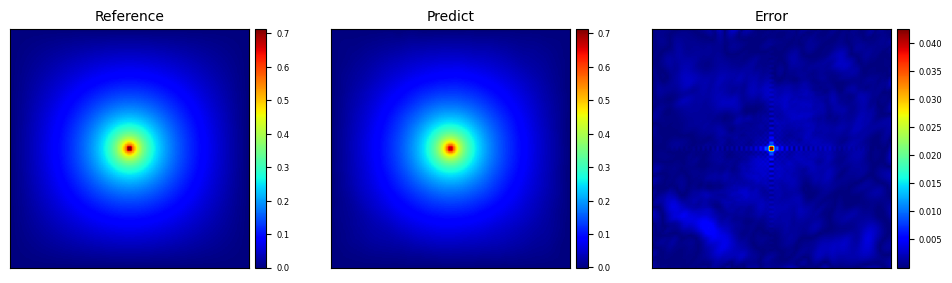

In [7]:
from src.utils import calculate_l2_error, visual

# Create the dataset
ds_test = create_test_dataset(config)

# Evaluate the model
calculate_l2_error(model, ds_test)

# Visual comparison of label and prediction
visual(model, ds_test)